In [1]:
import string
import sys
sys.path.append("/Users/jdemaray/Dropbox (Gladstone)/Jack/Computational/instrument_scripts/")


from qPCR import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

path = "/Users/jdemaray/Dropbox (Gladstone)/Jack/Experiments/EXPJ31/"

GOI_list = ['ACTB', 'ACTB', 'CCL20', 'CCL20', 'CX3CL1', 'CX3CL1'] \
+ [None for i in range(18)]
cell_lines = {
        "A"	: "34 (CCL20)",
        "B"	: "42 (CX3CL1)",
        "C"	: "35 (CCL20)",
        "D"	: "43 (CX3CL1)",
        "E"	: "36 (CCL20)",
        "F"	: "44 (CX3CL1)",
        "G"	: "37 (CCL20)",
        "H"	: "45 (CX3CL1)",
        "I"	: "38 (CCL20)",
        "J"	: "Transduction (-)",
        "K"	: "39 (CCL20)",
        "L"	: "Water",
        "M"	: "40 (CX3CL1)",
        "N"	: np.nan,
        "O"	: np.nan,
        "P"	: np.nan
    }

ctdf = pd.read_csv(path+'20231017_EXPJ31 -  Quantification Cq Results.csv')
define_genes_samples(ctdf, GOI_list, cell_lines)
ct384 = get_ct_384(ctdf)

# ct384.dropna()
# empty_wells = [letter + "02" for letter in string.ascii_uppercase[:14]] + \
#     [letter + "04" for letter in string.ascii_uppercase[:14]] + \
#     [letter + "06" for letter in string.ascii_uppercase[:14]]
# empty_wells
ct384.dropna(inplace=True)

ct384[['row', 'column']] = ct384["Well"].str.split("0", expand=True)
ct384.replace(0, np.nan, inplace=True)

layout = pd.DataFrame({i : {c : float(ct384.loc[(ct384.row == i) & (ct384.column == c), "Cq Mean"].values) for c in ct384.column.unique()} for i in ct384.row.unique()}).T
layout.sort_index(axis=1, inplace=True)
layout.sort_index(inplace=True)
layout.style.background_gradient(cmap='binary')

/var/folders/jv/gbxqq9fn27d28j169k55b6s00000gq/T/ipykernel_8283/3337435140.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  layout = pd.DataFrame({i : {c : float(ct384.loc[(ct384.row == i) & (ct384.column == c), "Cq Mean"].values) for c in ct384.column.unique()} for i in ct384.row.unique()}).T


,1,2,3,4,5,6
A,20.248980,18.304106,36.169653,34.306366,28.014476,25.760057
B,19.705885,18.084944,nan,nan,25.924185,24.151694
C,18.923976,17.416827,29.545559,28.099966,27.894169,25.565751
D,23.486453,17.208517,nan,40.187275,27.182016,21.611327
E,18.386181,16.831237,32.348783,28.775990,25.896701,24.234567
F,21.021452,17.521482,nan,35.189375,27.360062,22.685192
G,20.605436,17.265054,42.472642,31.779941,27.209774,24.010696
H,20.859768,17.642158,nan,33.037005,23.188153,18.124043
I,23.965614,18.064716,nan,34.555932,40.191679,30.851730
J,22.333206,19.524298,nan,37.783136,28.583908,nan


In [2]:
ct384

,Well,Cq Mean,GOI,Sample,row,column
0,A01,20.248980,ACTB,34 (CCL20),A,1
144,G01,20.605436,ACTB,37 (CCL20),G,1
168,H01,20.859768,ACTB,45 (CX3CL1),H,1
169,H02,17.642158,ACTB,45 (CX3CL1),H,2
121,F02,17.521482,ACTB,44 (CX3CL1),F,2
...,...,...,...,...,...,...
124,F05,27.360062,CX3CL1,44 (CX3CL1),F,5
125,F06,22.685192,CX3CL1,44 (CX3CL1),F,6
149,G06,24.010696,CX3CL1,37 (CCL20),G,6
52,C05,27.894169,CX3CL1,35 (CCL20),C,5


Samples **34-39** are CCL20

Samples **40-45** are CX3CL1

In [3]:
cols = ['ACTB_1', 'ACTB_2', 'CCL20_3', 'CCL20_4', 'CX3CL1_5', 'CX3CL1_6']
layout = pd.DataFrame({i : {c : float(ct384.loc[(ct384.Sample == i) & (ct384.column == c), "Cq Mean"].values) for c in ct384.column.unique()} for i in ct384.Sample.unique()}).T
layout.columns = cols
# layout = pd.DataFrame({i : {c : float(ct384.loc[(ct384.Sample == i) & (ct384.column == c), "Cq Mean"].values) for c in ct384.column.unique()} for i in ct384.Sample.unique()}).T
layout.sort_index(axis=1, inplace=True)
layout.sort_index(inplace=True)
layout.style.background_gradient(cmap='binary')

/var/folders/jv/gbxqq9fn27d28j169k55b6s00000gq/T/ipykernel_8283/4071458797.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  layout = pd.DataFrame({i : {c : float(ct384.loc[(ct384.Sample == i) & (ct384.column == c), "Cq Mean"].values) for c in ct384.column.unique()} for i in ct384.Sample.unique()}).T


,ACTB_1,ACTB_2,CCL20_3,CCL20_4,CX3CL1_5,CX3CL1_6
34 (CCL20),20.248980,18.304106,34.306366,36.169653,28.014476,25.760057
35 (CCL20),18.923976,17.416827,28.099966,29.545559,27.894169,25.565751
36 (CCL20),18.386181,16.831237,28.775990,32.348783,25.896701,24.234567
37 (CCL20),20.605436,17.265054,31.779941,42.472642,27.209774,24.010696
38 (CCL20),23.965614,18.064716,34.555932,nan,40.191679,30.851730
39 (CCL20),18.731037,17.626447,40.290725,36.381617,29.569426,nan
40 (CX3CL1),16.806002,28.922711,nan,nan,18.308326,nan
42 (CX3CL1),19.705885,18.084944,nan,nan,25.924185,24.151694
43 (CX3CL1),23.486453,17.208517,40.187275,nan,27.182016,21.611327
44 (CX3CL1),21.021452,17.521482,35.189375,nan,27.360062,22.685192


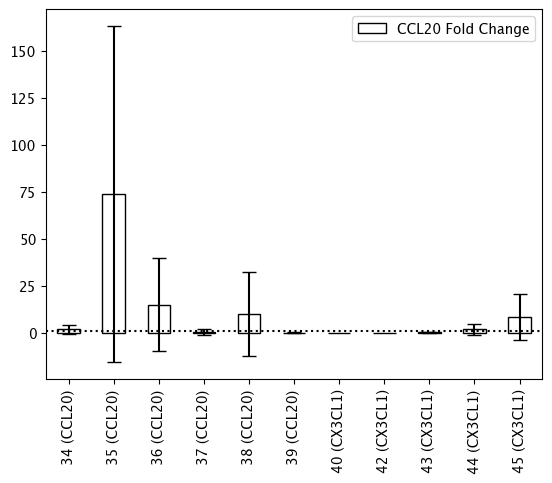

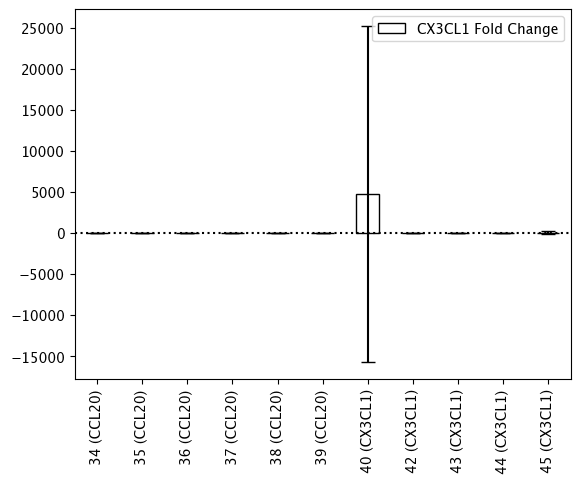

In [4]:
from uncertainties import ufloat

ct384.replace(0.0, 46.0, inplace=True)
ct_df = pd.DataFrame(columns=ct384.GOI.unique(), index=[i for i in ct384.Sample.unique() if i != "Water"])
for index, row in ct_df.iterrows():
    for gene in ct_df.columns:
        Ct = ct384.loc[(ct384["GOI"]==gene) & (ct384["Sample"]==index), "Cq Mean"]
        ct_df.loc[index, gene] = ufloat(np.mean(Ct), np.std(Ct))
        # print(ct384.loc[(ct384["GOI"]==gene) & (ct384["Sample"]==index)])
ct_df.sort_index(inplace=True)
dct_df = pd.DataFrame(columns=[i for i in ct_df.columns if i != "ACTB"], index=ct_df.index)
for index, row in dct_df.iterrows():
    for gene in dct_df.columns:
        dCt = ct_df.loc[index, gene] - ct_df.loc[index, "ACTB"]
        dct_df.loc[index, gene] = dCt
ddct_df = pd.DataFrame(columns=dct_df.columns, index=[i for i in dct_df.index if i != "Transduction (-)"])
for index, row in ddct_df.iterrows():
    for gene in ddct_df.columns:
        ddCt = dct_df.loc[index, gene] - dct_df.loc["Transduction (-)", gene]
        ddct_df.loc[index, gene] = ddCt
fold_changes = ddct_df.apply((lambda x: 2**-x))
unpacked_column_names = [f"{i} Fold Change" for i in ddct_df.columns]+\
                       [f"{i} stdev" for i in ddct_df.columns]
unpacked_column_names.sort()
fc_plot = pd.DataFrame(columns=unpacked_column_names,
                       index=ddct_df.index)
fc_plot
# fc_plot.columns.sort_values()
for index, row in fc_plot.iterrows():
    for gene in fold_changes.columns:
        fc_plot.loc[index, f"{gene} Fold Change"]=fold_changes.loc[index, gene].nominal_value
        fc_plot.loc[index, f"{gene} stdev"]=float(fold_changes.loc[index, gene].std_dev)
# fold_changes.hist()
fc_plot.plot.bar(y="CCL20 Fold Change", facecolor="none", edgecolor='k', capsize=5, yerr="CCL20 stdev")
plt.axhline(y=1, c='k', linestyle=':')
fc_plot.plot.bar(y="CX3CL1 Fold Change", facecolor="none", edgecolor='k', capsize=5, yerr="CX3CL1 stdev")
plt.axhline(y=1, c='k', linestyle=':')
# plt.hist(x=fc_plot, bins=fc_plot.index)

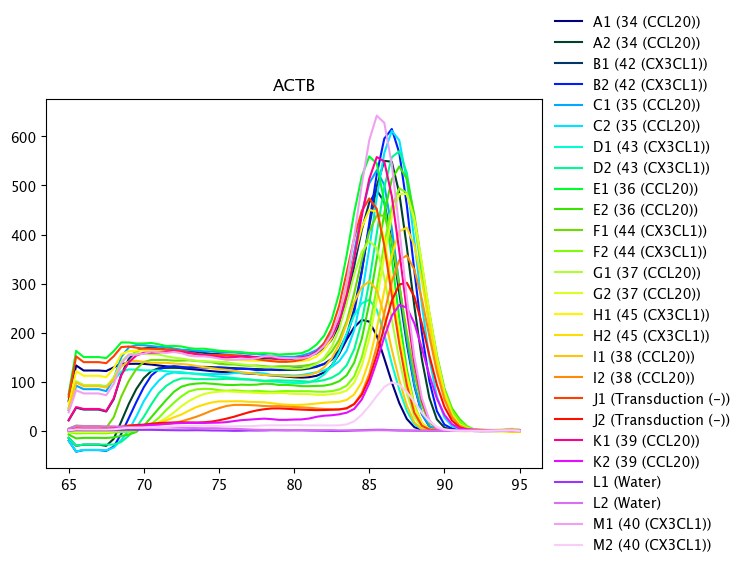

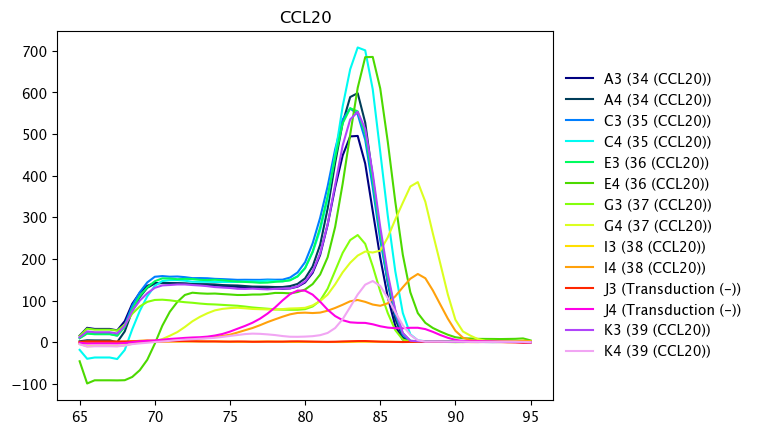

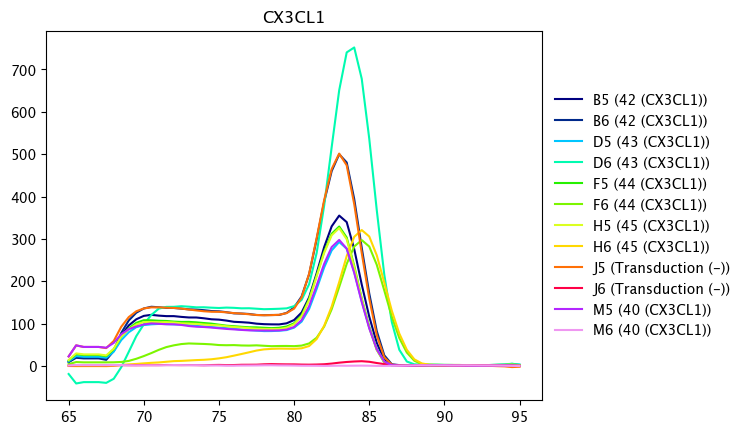

In [5]:
mcdf = process_mc_384(path+"20231017_EXPJ31 -  Melt Curve Derivative Results_SYBR.csv", GOI_list, cell_lines)

# empty_wells_mc = [letter + "2" for letter in string.ascii_uppercase[:14]] + \
#     [letter + "4" for letter in string.ascii_uppercase[:14]] + \
#     [letter + "6" for letter in string.ascii_uppercase[:14]]

mcdf.dropna(inplace=True)
# mcdf = mcdf[~mcdf["index"].isin(empty_wells_mc)]

for gene in pd.Series(GOI_list).unique():
    if gene:
        if gene in ["CCL20", "CX3CL1"]:
            plot_mc_384(
                mcdf.loc[(mcdf["Sample"].str.contains("n/a")) | (mcdf["Sample"].str.contains(gene)) | (mcdf["Sample"].str.contains("Transduction (-)", regex=False))], 
                gene, 
                cmap='gist_ncar')
        else:
            plot_mc_384(mcdf, gene, cmap='gist_ncar')

In [6]:

# mcdf.Sample.unique()
# (mcdf["Sample"].str.contains("CCL20")) | (mcdf["Sample"].str.contains("Transduction (-)"))
mcdf

,index,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,60,GOI,Sample
0,Temperature,65.000000,65.500000,66.000000,66.500000,67.000000,67.500000,68.000000,68.500000,69.000000,...,91.500000,92.000000,92.500000,93.000000,93.500000,94.000000,94.500000,95.000000,n/a,n/a
1,A1,61.758099,133.809214,123.516197,123.516197,123.516197,122.426090,130.019907,137.908445,137.061153,...,0.892577,0.515511,0.398342,0.623886,0.574349,0.628818,0.818373,0.389837,ACTB,34 (CCL20)
2,A2,-13.661642,-29.600224,-27.323284,-27.323284,-27.323284,-29.792672,-15.457467,19.658375,55.453467,...,1.096872,1.022685,0.923621,1.313044,2.275537,2.786916,4.275706,2.603658,ACTB,34 (CCL20)
3,A3,15.941955,34.540903,31.883910,31.883910,31.883910,28.327935,50.563294,92.278951,118.691781,...,0.876385,0.777986,0.961776,0.988997,0.953449,0.784551,1.383683,0.982104,CCL20,34 (CCL20)
4,A4,2.159095,4.678038,4.318189,4.318189,4.318189,0.178826,25.943763,75.077415,108.208249,...,0.680903,0.433223,0.300575,0.544432,0.826319,0.885823,1.012675,0.442102,CCL20,34 (CCL20)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,M2,1.766168,3.826698,3.532336,3.532336,3.532336,3.443914,3.922506,5.458444,6.829771,...,0.966874,1.067101,0.943180,1.034985,1.339883,1.261434,1.445374,0.741155,ACTB,40 (CX3CL1)
291,M3,2.693133,5.835121,5.386266,5.386266,5.386266,5.161366,6.531659,9.371965,11.592251,...,0.720397,0.314526,0.269995,0.172533,0.471121,0.830979,2.140317,1.559108,CCL20,40 (CX3CL1)
292,M4,2.141249,4.639373,4.282498,4.282498,4.282498,4.317751,4.071181,3.824813,3.856442,...,0.909597,0.786323,1.016347,0.962326,0.229636,-0.137816,-1.164955,-1.077743,CCL20,40 (CX3CL1)
293,M5,22.387078,48.505335,44.774155,44.774155,44.774155,42.990807,54.203834,74.856287,86.591074,...,0.628241,0.392060,0.530254,0.822522,0.971115,1.159044,1.287040,0.509339,CX3CL1,40 (CX3CL1)


In [7]:
mcdf

,index,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,60,GOI,Sample
0,Temperature,65.000000,65.500000,66.000000,66.500000,67.000000,67.500000,68.000000,68.500000,69.000000,...,91.500000,92.000000,92.500000,93.000000,93.500000,94.000000,94.500000,95.000000,n/a,n/a
1,A1,61.758099,133.809214,123.516197,123.516197,123.516197,122.426090,130.019907,137.908445,137.061153,...,0.892577,0.515511,0.398342,0.623886,0.574349,0.628818,0.818373,0.389837,ACTB,34 (CCL20)
2,A2,-13.661642,-29.600224,-27.323284,-27.323284,-27.323284,-29.792672,-15.457467,19.658375,55.453467,...,1.096872,1.022685,0.923621,1.313044,2.275537,2.786916,4.275706,2.603658,ACTB,34 (CCL20)
3,A3,15.941955,34.540903,31.883910,31.883910,31.883910,28.327935,50.563294,92.278951,118.691781,...,0.876385,0.777986,0.961776,0.988997,0.953449,0.784551,1.383683,0.982104,CCL20,34 (CCL20)
4,A4,2.159095,4.678038,4.318189,4.318189,4.318189,0.178826,25.943763,75.077415,108.208249,...,0.680903,0.433223,0.300575,0.544432,0.826319,0.885823,1.012675,0.442102,CCL20,34 (CCL20)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,M2,1.766168,3.826698,3.532336,3.532336,3.532336,3.443914,3.922506,5.458444,6.829771,...,0.966874,1.067101,0.943180,1.034985,1.339883,1.261434,1.445374,0.741155,ACTB,40 (CX3CL1)
291,M3,2.693133,5.835121,5.386266,5.386266,5.386266,5.161366,6.531659,9.371965,11.592251,...,0.720397,0.314526,0.269995,0.172533,0.471121,0.830979,2.140317,1.559108,CCL20,40 (CX3CL1)
292,M4,2.141249,4.639373,4.282498,4.282498,4.282498,4.317751,4.071181,3.824813,3.856442,...,0.909597,0.786323,1.016347,0.962326,0.229636,-0.137816,-1.164955,-1.077743,CCL20,40 (CX3CL1)
293,M5,22.387078,48.505335,44.774155,44.774155,44.774155,42.990807,54.203834,74.856287,86.591074,...,0.628241,0.392060,0.530254,0.822522,0.971115,1.159044,1.287040,0.509339,CX3CL1,40 (CX3CL1)


# 20231018 repeat

In [8]:
import string
import sys
sys.path.append("/Users/jdemaray/Dropbox (Gladstone)/Jack/Computational/instrument_scripts/")


from qPCR import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

path = "/Users/jdemaray/Dropbox (Gladstone)/Jack/Experiments/EXPJ31/"

GOI_list = [None for i in range(12)] + \
['ACTB', None, 'ACTB', None, 'CCL20', None, 'CCL20', None, 'CX3CL1', None, 'CX3CL1', None]
cell_lines = {
        "A"	: "34 (CCL20)",
        "B"	: "42 (CX3CL1)",
        "C"	: "35 (CCL20)",
        "D"	: "43 (CX3CL1)",
        "E"	: "36 (CCL20)",
        "F"	: "44 (CX3CL1)",
        "G"	: "37 (CCL20)",
        "H"	: "45 (CX3CL1)",
        "I"	: "38 (CCL20)",
        "J"	: "Transduction (-)",
        "K"	: "39 (CCL20)",
        "L"	: "Water",
        "M"	: "40 (CX3CL1)",
        "N"	: np.nan,
        "O"	: np.nan,
        "P"	: np.nan
    }

ctdf = pd.read_csv(path+'20231018_EXPJ31_repeat -  Quantification Cq Results.csv')
define_genes_samples(ctdf, GOI_list, cell_lines)
ct384 = get_ct_384(ctdf)

# ct384.dropna()
# empty_wells = [letter + "02" for letter in string.ascii_uppercase[:14]] + \
#     [letter + "04" for letter in string.ascii_uppercase[:14]] + \
#     [letter + "06" for letter in string.ascii_uppercase[:14]]
# empty_wells
ct384.dropna(inplace=True)

# ct384[['row']] = ct384["Well"].str[0]
# ct384[['column']] = ct384["Well"].str[1:]
ct384[['row', 'column']] = ct384["Well"].str.split("([A-P])", expand=True, regex=True).iloc[:, 1:]
ct384.replace(0, np.nan, inplace=True)

layout = pd.DataFrame({i : {c : float(ct384.loc[(ct384.row == i) & (ct384.column == c), "Cq Mean"].values) for c in ct384.column.unique()} for i in ct384.row.unique()}).T
layout.sort_index(axis=1, inplace=True)
layout.sort_index(inplace=True)
layout.style.background_gradient(cmap='binary')

/var/folders/jv/gbxqq9fn27d28j169k55b6s00000gq/T/ipykernel_8283/3363912176.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  layout = pd.DataFrame({i : {c : float(ct384.loc[(ct384.row == i) & (ct384.column == c), "Cq Mean"].values) for c in ct384.column.unique()} for i in ct384.row.unique()}).T


,13,15,17,19,21,23
A,18.074951,18.087513,31.530844,31.289843,nan,nan
B,18.009219,17.533444,nan,nan,21.508591,21.930762
C,17.777528,17.970678,26.531963,27.127532,nan,nan
D,16.300799,16.545828,nan,nan,20.939969,21.063330
E,17.212402,17.337271,29.107114,29.458262,nan,nan
F,17.295942,17.951284,nan,nan,22.096495,22.148796
G,17.073266,17.374237,37.530861,35.783444,nan,nan
H,18.256085,18.569569,nan,nan,18.155936,17.621114
I,17.871194,18.072368,40.137936,39.543496,nan,nan
J,19.934984,19.630225,42.568676,38.673845,26.338133,26.584631


In [9]:
cols = ['ACTB_1', 'ACTB_2', 'CCL20_3', 'CCL20_4', 'CX3CL1_5', 'CX3CL1_6']
layout = pd.DataFrame({i : {c : float(ct384.loc[(ct384.Sample == i) & (ct384.column == c), "Cq Mean"].values) for c in ct384.column.unique()} for i in ct384.Sample.unique()}).T
layout.columns = cols
# layout = pd.DataFrame({i : {c : float(ct384.loc[(ct384.Sample == i) & (ct384.column == c), "Cq Mean"].values) for c in ct384.column.unique()} for i in ct384.Sample.unique()}).T
layout.sort_index(axis=1, inplace=True)
layout.sort_index(inplace=True)
layout.style.background_gradient(cmap='binary')

/var/folders/jv/gbxqq9fn27d28j169k55b6s00000gq/T/ipykernel_8283/4071458797.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  layout = pd.DataFrame({i : {c : float(ct384.loc[(ct384.Sample == i) & (ct384.column == c), "Cq Mean"].values) for c in ct384.column.unique()} for i in ct384.Sample.unique()}).T


,ACTB_1,ACTB_2,CCL20_3,CCL20_4,CX3CL1_5,CX3CL1_6
34 (CCL20),18.074951,18.087513,31.289843,31.530844,nan,nan
35 (CCL20),17.777528,17.970678,27.127532,26.531963,nan,nan
36 (CCL20),17.212402,17.337271,29.458262,29.107114,nan,nan
37 (CCL20),17.073266,17.374237,35.783444,37.530861,nan,nan
38 (CCL20),17.871194,18.072368,39.543496,40.137936,nan,nan
39 (CCL20),17.860786,17.432184,32.683703,32.709992,nan,nan
40 (CX3CL1),16.691211,16.407539,nan,nan,15.247273,15.499576
42 (CX3CL1),18.009219,17.533444,nan,nan,21.508591,21.930762
43 (CX3CL1),16.300799,16.545828,nan,nan,20.939969,21.063330
44 (CX3CL1),17.295942,17.951284,nan,nan,22.096495,22.148796


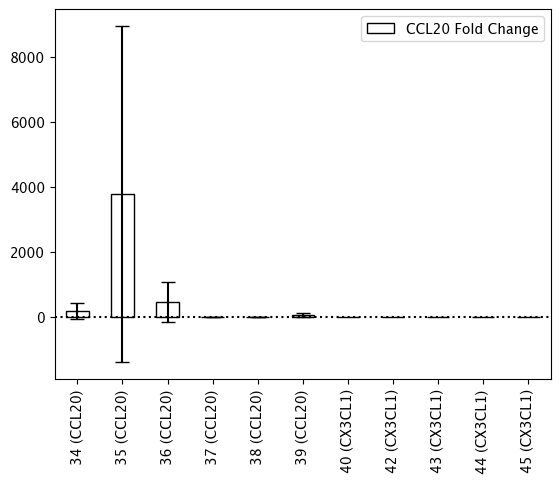

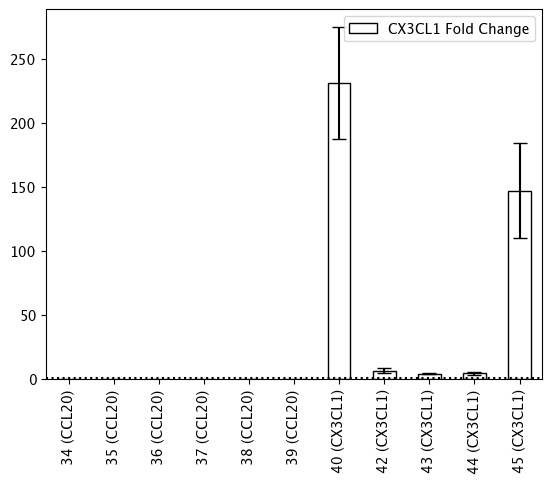

In [42]:
from uncertainties import ufloat

ct384.replace(0.0, 46.0, inplace=True)
ct_df = pd.DataFrame(columns=ct384.GOI.unique(), index=[i for i in ct384.Sample.unique() if i != "Water"])
for index, row in ct_df.iterrows():
    for gene in ct_df.columns:
        Ct = ct384.loc[(ct384["GOI"]==gene) & (ct384["Sample"]==index), "Cq Mean"]
        ct_df.loc[index, gene] = ufloat(np.mean(Ct), np.std(Ct))
        # print(ct384.loc[(ct384["GOI"]==gene) & (ct384["Sample"]==index)])
ct_df.sort_index(inplace=True)
dct_df = pd.DataFrame(columns=[i for i in ct_df.columns if i != "ACTB"], index=ct_df.index)
for index, row in dct_df.iterrows():
    for gene in dct_df.columns:
        dCt = ct_df.loc[index, gene] - ct_df.loc[index, "ACTB"]
        dct_df.loc[index, gene] = dCt
ddct_df = pd.DataFrame(columns=dct_df.columns, index=[i for i in dct_df.index if i != "Transduction (-)"])
for index, row in ddct_df.iterrows():
    for gene in ddct_df.columns:
        ddCt = dct_df.loc[index, gene] - dct_df.loc["Transduction (-)", gene]
        ddct_df.loc[index, gene] = ddCt
fold_changes = ddct_df.apply((lambda x: 2**-x))
unpacked_column_names = [f"{i} Fold Change" for i in ddct_df.columns]+\
                       [f"{i} stdev" for i in ddct_df.columns]
unpacked_column_names.sort()
fc_plot = pd.DataFrame(columns=unpacked_column_names,
                       index=ddct_df.index)
# fc_plot.columns.sort_values()
for index, row in fc_plot.iterrows():
    for gene in fold_changes.columns:
        fc_plot.loc[index, f"{gene} Fold Change"]=fold_changes.loc[index, gene].nominal_value
        fc_plot.loc[index, f"{gene} stdev"]=float(fold_changes.loc[index, gene].std_dev)
# fold_changes.hist()
fc_plot.plot.bar(y="CCL20 Fold Change", facecolor="none", edgecolor='k', capsize=5, yerr="CCL20 stdev")
plt.axhline(y=1, c='k', linestyle=':')
fc_plot.plot.bar(y="CX3CL1 Fold Change", facecolor="none", edgecolor='k', capsize=5, yerr="CX3CL1 stdev")
plt.axhline(y=1, c='k', linestyle=':')
# plt.hist(x=fc_plot, bins=fc_plot.index)

## Calculate the theoretical efficiencies 
Note: instead of using the transduction efficiency, I use the proportion of cells that are GFP+ / mCherry+ (dCas9+ / sgRNA+) since those should be the ones with activation
$$E = a\epsilon + (1-\epsilon)$$
$$f = \frac{E}{E_0}$$
Let's just say  E<sub>0</sub> = 1. Then the first equation just indicates fold change
$$E_0 = 1 \implies f = E$$
$$\therefore a = \frac{f + \epsilon - 1}{\epsilon}\$$
a = activation, ϵ = efficiency, f = fold change, E = expression, E<sub>0</sub> = expression at baseline

In [47]:
efficiencies = {
"34 (CCL20)" : 0.473,
"35 (CCL20)" : 0.487,
"36 (CCL20)" : 0.435,
"37 (CCL20)" : 0.477,
"38 (CCL20)" : 0.466,
"39 (CCL20)" : 0.417,
"40 (CX3CL1)" : 0.485,
"41 (CX3CL1)" : 0.411,
"42 (CX3CL1)" : 0.473,
"43 (CX3CL1)" : 0.448,
"44 (CX3CL1)" : 0.435,
"45 (CX3CL1)" : 0.421
}
fold_changes["efficiency"] = efficiencies
fold_changes.dtypes
fold_changes["CCL20_estimated_activation"] = (fold_changes["CCL20"] + fold_changes["efficiency"] - 1) / fold_changes["efficiency"]
fold_changes["CX3CL1_estimated_activation"] = (fold_changes["CX3CL1"] + fold_changes["efficiency"] - 1) / fold_changes["efficiency"]
# fold_changes.index.str.split(" ", expand=True)
# [efficiencies[s] for s, _ in fold_changes.index.str.split(" ", expand=True)]
# fc_plot = fc_plot * [efficiencies[s] for s, _ in fold_changes.index.str.split(" ", expand=True)]

In [50]:
fold_changes.loc["40 (CX3CL1)", ["CX3CL1", "CX3CL1_estimated_activation"]].apply(lambda x: x.nominal_value)

CX3CL1                         231.477596
CX3CL1_estimated_activation    476.211538
Name: 40 (CX3CL1), dtype: float64

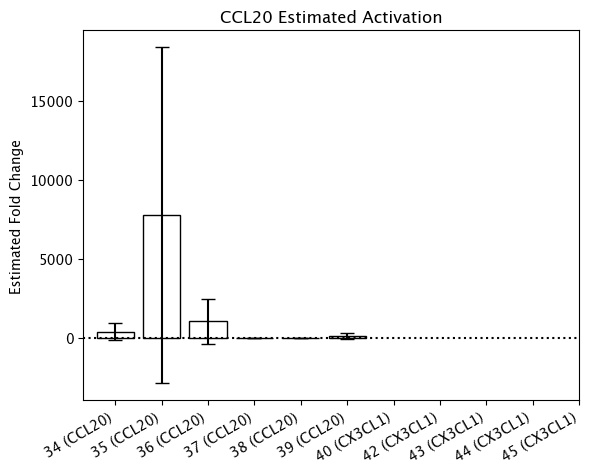

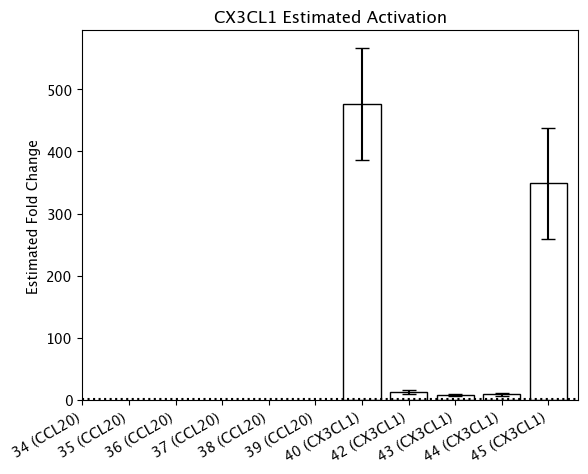

In [41]:
# Plotting estimated efficiencies
values = fold_changes["CCL20_estimated_activation"].apply(lambda x: x.nominal_value)
stdevs = fold_changes["CCL20_estimated_activation"].apply(lambda x: x.std_dev)
x = np.arange(len(values))
plt.bar(x, values, yerr=stdevs, capsize=5, facecolor='none', edgecolor='k', align='center')
plt.ylabel("Estimated Fold Change")
plt.xticks(x, fold_changes.index, rotation=30, ha='right')
plt.axhline(y=1, c='k', linestyle=':')
plt.title("CCL20 Estimated Activation")
plt.show()

values = fold_changes["CX3CL1_estimated_activation"].apply(lambda x: x.nominal_value)
stdevs = fold_changes["CX3CL1_estimated_activation"].apply(lambda x: x.std_dev)
x = np.arange(len(values))
plt.bar(x, values, yerr=stdevs, capsize=5, facecolor='none', edgecolor='k', align='center')
plt.ylabel("Estimated Fold Change")
plt.xticks(x, fold_changes.index, rotation=30, ha='right')
plt.axhline(y=1, c='k', linestyle=':')
plt.title("CX3CL1 Estimated Activation")
plt.show()

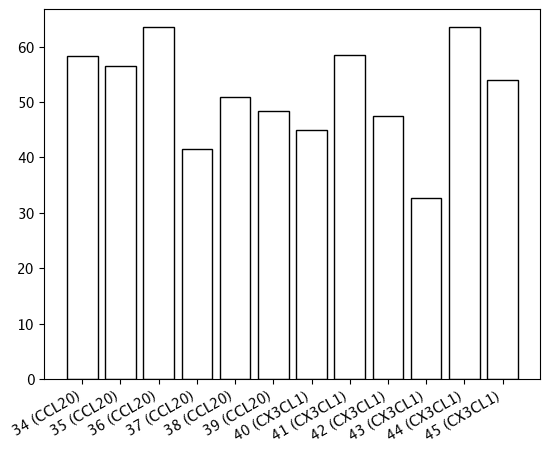

In [58]:
sample_to_primer = {
"34 (CCL20)" :  "8", 
"35 (CCL20)" :  "9", 
"36 (CCL20)" :  "10", 
"37 (CCL20)" :  "11", 
"38 (CCL20)" :  "12", 
"39 (CCL20)" :  "13", 
"40 (CX3CL1)" : "14", 
"41 (CX3CL1)" : "15", 
"42 (CX3CL1)" : "16", 
"43 (CX3CL1)" : "17", 
"44 (CX3CL1)" : "18", 
"45 (CX3CL1)" : "19" 
}
primer_to_eff = {
"8"  : 58.39,
"9"  : 56.55,
"10" : 63.51,
"11" : 41.43,
"12" : 50.85,
"13" : 48.43,
"14" : 44.93,
"15" : 58.47,
"16" : 47.45,
"17" : 32.74,
"18" : 63.53,
"19" : 53.93
}
plt.bar(
    x = np.arange(len(primer_to_eff)),
    height= [v for i, v in primer_to_eff.items()], 
    facecolor='none', 
    edgecolor='k'
)
plt.xticks(np.arange(len(primer_to_eff)), [i for i, _ in sample_to_primer.items()], rotation=30, ha='right')
plt.show()